In [44]:
from google.colab import drive
import sys
drive.mount('/content/drive')
sys.path.append("/content/drive/MyDrive/")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch
import torchvision.transforms as transforms
import torch.optim.lr_scheduler as lr_scheduler 
import cv2 


In [46]:
df_Train = pd.read_csv('/content/drive/MyDrive/Q3_train.csv')
df_test  = pd.read_csv('/content/drive/MyDrive/Q3_test.csv')

In [4]:
Y_train=df_Train['label']
Y_train[Y_train>9]-=1
X_train=df_Train.drop(['label'],axis=1).values
Y_test=df_test['label']
Y_test[Y_test>9]-=1
X_test=df_test.drop(['label'],axis=1).values

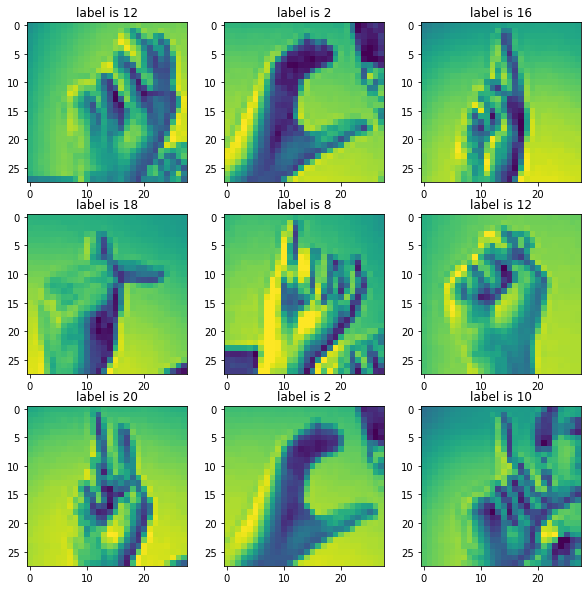

In [41]:
idx=np.random.randint(low=0,high=len(X_train),size=(9))
Y_ran=Y_train[idx]
X_ran=X_train[idx].reshape(-1,28,28)
plt.figure(figsize=[10,10])
cnt=1
for i,j in zip(Y_ran,X_ran):
    plt.subplot(3,3,cnt)
    plt.imshow(j)
    plt.title(f"label is {i}")
    cnt+=1

In [6]:
Onehot_label=np.zeros((len(Y_train),24))
Onehot_label[np.arange(len(Y_train)),Y_train.astype(int)]=1.0

Onehot_label_test=np.zeros((len(Y_test),24))
Onehot_label_test[np.arange(len(Y_test)),Y_test.astype(int)]=1.0


x_train, x_validation, y_train, y_validation=train_test_split(X_train,Onehot_label,test_size=0.2)


x_train=torch.tensor(x_train/255).float()
x_validation=torch.tensor(x_validation/255).float()
X_test=torch.tensor(X_test/255).float()

x_train = torch.utils.data.DataLoader(x_train,batch_size=64,shuffle=False)
x_validation = torch.utils.data.DataLoader(x_validation,batch_size=64,shuffle=False)
y_train = torch.utils.data.DataLoader(y_train,batch_size=64,shuffle=False)
y_validation = torch.utils.data.DataLoader(y_validation,batch_size=64,shuffle=False)

In [7]:
class MLP_net(nn.Module):
    def __init__(self,prob):
        super(MLP_net,self).__init__()

        self.input_layer=nn.Linear(784,1024)
        self.hidden_layer1=nn.Linear(1024,512)
        self.hidden_layer2=nn.Linear(512,256)
        self.output_layer=nn.Linear(256,24)
        self.drop1 = nn.Dropout(p=prob)

        nn.init.xavier_normal_(self.input_layer.weight)
        nn.init.xavier_normal_(self.hidden_layer1.weight)
        nn.init.xavier_normal_(self.hidden_layer2.weight)
        nn.init.xavier_normal_(self.output_layer.weight)


    def forward(self,x):
        x = self.drop1(F.relu(self.input_layer(x)))
        x = self.drop1(F.relu(self.hidden_layer1(x)))
        x = self.drop1(F.relu(self.hidden_layer2(x)))
        x = self.output_layer(x)
        return x

In [8]:
def Acc(output,true_labels):
    correct=0
    for i,j in zip(output,true_labels):
        if torch.argmax(i)==torch.argmax(j):
            correct+=1
    return correct/len(output)

def Train(model,lr,Epochs,x_train, x_validation, y_train, y_validation,optim='Adam'):

  min_loss=9999
  criterion=nn.CrossEntropyLoss()
  if optim=='Adam':
      optimizer=torch.optim.Adam(model.parameters(),lr=lr,weight_decay=1e-4)
  elif optim=='SGD' :
      print('SGD')
      optimizer=torch.optim.SGD(model.parameters(),lr=lr) 
  scheduler=lr_scheduler.CosineAnnealingLR(optimizer,T_max=100,eta_min=1e-4)
  Train_Acc_array=[]
  validation_Acc_array=[]
  Train_Lr=[]
  for i in range(Epochs):
    # ****************** Training *******************
    model.train()
    Loss_train=[]
    Acc_train=[]
    print(f'###################### Epoch {i} #####################')
    for data,label in zip(x_train,y_train):
      data,label=data.cuda().float(),label.cuda().float()
      optimizer.zero_grad()
      output=model(data)
      Loss=criterion(output,label)
      Loss.backward()
      optimizer.step()
      Loss_train.append(Loss)
      Acc_train.append(Acc(output,label))
    Train_Lr.append(scheduler.get_last_lr())
    scheduler.step()
    Train_Acc_array.append(torch.mean(torch.tensor(Acc_train)))
    print(f'Train Cross Entropy Loss {torch.mean(torch.tensor(Loss_train))}')
    print(f'Train Accuracy is {Train_Acc_array[-1]*100}')
    # ****************** Test  *******************
    model.eval()
    Loss_val=[]
    Acc_test=[]
    for data,label in zip(x_validation,y_validation):
      data,label=data.cuda().float(),label.cuda().float()
      output=model(data)
      Loss=criterion(output,label)
      Loss_val.append(Loss)
      Acc_test.append(Acc(output,label))
      
    validation_Acc_array.append(torch.mean(torch.tensor(Acc_test)))
    print(f'Validation Cross Entropy Loss {torch.mean(torch.tensor(Loss_val))}')
    print(f'Validation Accuracy is {validation_Acc_array[-1]*100}')
    print('#######################################################')
    if min_loss>torch.mean(torch.tensor(Loss_val))+torch.mean(torch.tensor(Loss_train)):
      print("saving best model")
      best_model=model
      min_loss=torch.mean(torch.tensor(Loss_val))+torch.mean(torch.tensor(Loss_train))
  return Train_Acc_array,validation_Acc_array,best_model,Train_Lr

# ب

SGD
###################### Epoch 0 #####################
Train Cross Entropy Loss 2.882934808731079
Train Accuracy is 22.298934936523438
Validation Cross Entropy Loss 2.582611322402954
Validation Accuracy is 22.575382232666016
#######################################################
saving best model
###################### Epoch 1 #####################
Train Cross Entropy Loss 2.1638104915618896
Train Accuracy is 40.575035095214844
Validation Cross Entropy Loss 2.13759708404541
Validation Accuracy is 31.628334045410156
#######################################################
saving best model
###################### Epoch 2 #####################
Train Cross Entropy Loss 1.6876635551452637
Train Accuracy is 50.520835876464844
Validation Cross Entropy Loss 2.032656192779541
Validation Accuracy is 36.125240325927734
#######################################################
saving best model
###################### Epoch 3 #####################
Train Cross Entropy Loss 1.4005190134048462
Train A

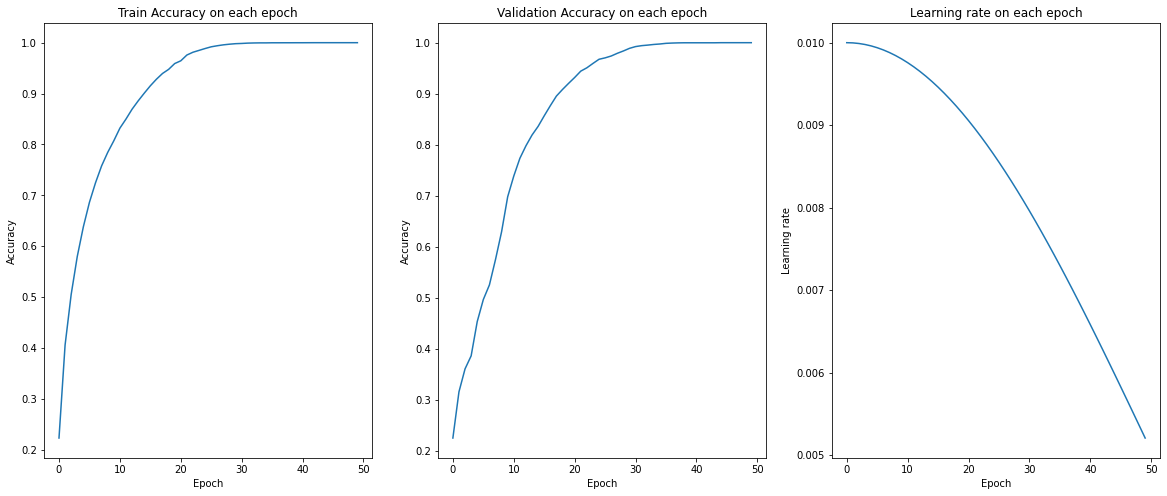

In [55]:
# SGD
model=MLP_net(prob=0).cuda()   
Train_Acc_array,Test_Acc_array,best_model,Train_Lr=Train(model=model,lr=1e-2,Epochs=50,x_train=x_train, x_validation=x_validation, y_train=y_train, y_validation=y_validation,optim='SGD')
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(Train_Acc_array)
plt.title('Train Accuracy on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,2)
plt.plot(Test_Acc_array)
plt.title('Validation Accuracy on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,3)
plt.plot(Train_Lr)
plt.title('Learning rate on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
best_model.eval()
output=best_model(X_test.cuda())

print("test accuracy is ",Acc(output,torch.tensor(Onehot_label_test))*100)

###################### Epoch 0 #####################
Train Cross Entropy Loss 1.9845211505889893
Train Accuracy is 36.479530334472656
Validation Cross Entropy Loss 1.3446568250656128
Validation Accuracy is 56.879486083984375
#######################################################
saving best model
###################### Epoch 1 #####################
Train Cross Entropy Loss 0.9425023198127747
Train Accuracy is 68.34272003173828
Validation Cross Entropy Loss 0.7828701734542847
Validation Accuracy is 72.50484466552734
#######################################################
saving best model
###################### Epoch 2 #####################
Train Cross Entropy Loss 0.514582633972168
Train Accuracy is 82.18114471435547
Validation Cross Entropy Loss 0.4164586663246155
Validation Accuracy is 85.66889190673828
#######################################################
saving best model
###################### Epoch 3 #####################
Train Cross Entropy Loss 0.3131771683692932
Train Accur

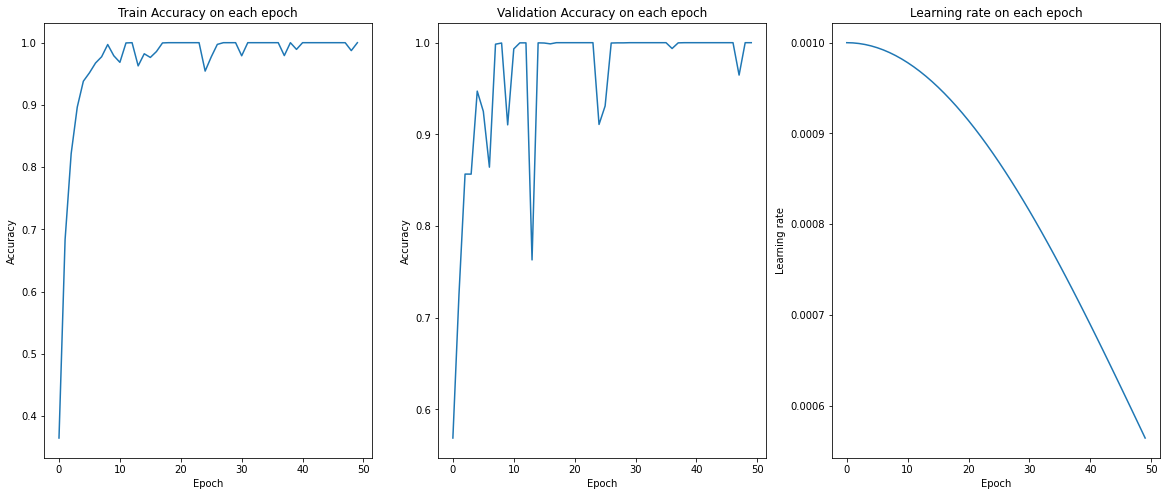

In [56]:
# Adam
model=MLP_net(prob=0).cuda()   
Train_Acc_array,Test_Acc_array,best_model,Train_Lr=Train(model=model,lr=1e-3,Epochs=50,x_train=x_train, x_validation=x_validation, y_train=y_train, y_validation=y_validation,optim='Adam')
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(Train_Acc_array)
plt.title('Train Accuracy on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,2)
plt.plot(Test_Acc_array)
plt.title('Validation Accuracy on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,3)
plt.plot(Train_Lr)
plt.title('Learning rate on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
best_model.eval()
output=best_model(X_test.cuda())

print("test accuracy is ",Acc(output,torch.tensor(Onehot_label_test))*100)

# Adam Vs SGD
Adam is so better than SGD because of using the moving average on the gradient and the second momentum of the gradient then use those as an update gradient and learning rate this algorithm can easily go through the saddle point and reach  the global minimum and test accuracy by adam is more than SGD

# **ج**

###################### Epoch 0 #####################
Train Cross Entropy Loss 2.3367416858673096
Train Accuracy is 25.890260696411133
Validation Cross Entropy Loss 1.5547655820846558
Validation Accuracy is 47.235877990722656
#######################################################
saving best model
###################### Epoch 1 #####################
Train Cross Entropy Loss 1.3482316732406616
Train Accuracy is 53.80026626586914
Validation Cross Entropy Loss 0.8650556206703186
Validation Accuracy is 71.18779754638672
#######################################################
saving best model
###################### Epoch 2 #####################
Train Cross Entropy Loss 0.9546336531639099
Train Accuracy is 66.96796417236328
Validation Cross Entropy Loss 0.6067510843276978
Validation Accuracy is 79.11857604980469
#######################################################
saving best model
###################### Epoch 3 #####################
Train Cross Entropy Loss 0.7366644144058228
Train Accu

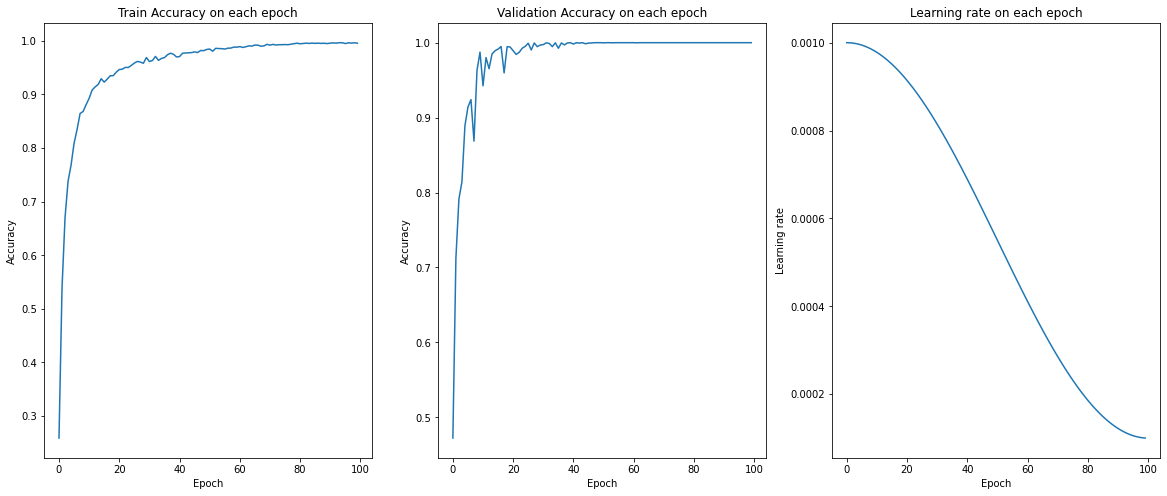

In [9]:
# Adam
model=MLP_net(prob=0.2).cuda()   
Train_Acc_array,Test_Acc_array,best_model,Train_Lr=Train(model=model,lr=1e-3,Epochs=100,x_train=x_train, x_validation=x_validation, y_train=y_train, y_validation=y_validation,optim='Adam')
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(Train_Acc_array)
plt.title('Train Accuracy on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,2)
plt.plot(Test_Acc_array)
plt.title('Validation Accuracy on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,3)
plt.plot(Train_Lr)
plt.title('Learning rate on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
best_model.eval()
output=best_model(X_test.cuda())

print("test accuracy is ",Acc(output,torch.tensor(Onehot_label_test))*100)

# why dropout worked!!
By Adding dropout to the model, test Accuracy increased Because of adding some noise to neurons different features are learned  and  this can be useful 

# د

test accuracy is  86.54489682097044


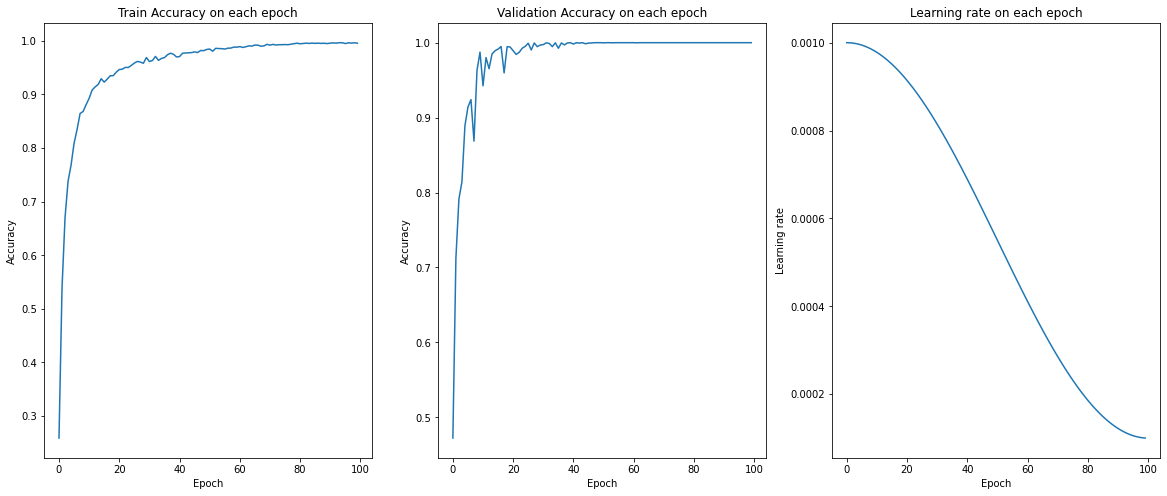

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(1,3,1)
plt.plot(Train_Acc_array)
plt.title('Train Accuracy on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,2)
plt.plot(Test_Acc_array)
plt.title('Validation Accuracy on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1,3,3)
plt.plot(Train_Lr)
plt.title('Learning rate on each epoch')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
best_model.eval()
output=best_model(X_test.cuda())

print("test accuracy is ",Acc(output,torch.tensor(Onehot_label_test))*100)

# ه

In [53]:
A=np.mean(cv2.resize(cv2.imread('/content/drive/MyDrive/1.jpg'),dsize=(28,28)),axis=2)
# B=np.mean(cv2.resize(cv2.imread('/content/drive/MyDrive/2.jpg'),dsize=(28,28)),axis=2)
# C=np.mean(cv2.resize(cv2.imread('/content/drive/MyDrive/3.jpg'),dsize=(28,28)),axis=2)


Label is  tensor(14, device='cuda:0')


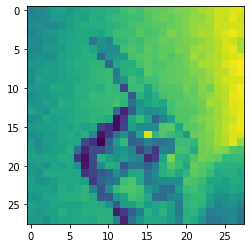

In [54]:
plt.imshow(A)
print("Label is ",torch.argmax(best_model(torch.tensor(A.reshape(1,-1)).cuda().float())))